In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import pandas as pd
import matplotlib, collections, itertools, os, re, textwrap, logging
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from functools import reduce

from logging.config import dictConfig
from logging import getLogger

dictConfig(dict(
    version = 1,
    formatters = {'f': {'format': '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}},
    handlers = {
        'h': {'class': 'logging.StreamHandler','formatter': 'f',
              'level': logging.DEBUG}},
    root = {'handlers': ['h'], 'level': logging.DEBUG,},
))

matplotlib.rc('font',**{'size':18, 'family':'sans-serif','sans-serif':['HelveticaNeue', 'Helvetica']})

logger = getLogger('notebook')


In [3]:
import yt_misc_py as yt_misc

import rivas_decomposition_py as decomposition


In [4]:
repo_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))))

out_dir = os.path.join(
    repo_dir, 'figs', os.path.basename(os.path.realpath(os.getcwd())),
)


In [5]:
d_all = decomposition.decomposition(os.path.join(
    repo_dir, 'private_data', 'npz', 'dev_allNonMHC_z_center_p0001_100PCs_20180129.npz'
))


2018-08-20 14:40:53,675 data_load_from_npz INFO     reading data from /Users/yosuke/repos/rivas-lab/decomposition/private_data/npz/dev_allNonMHC_z_center_p0001_100PCs_20180129.npz


In [6]:
phe_set = set(d_all.d['label_phe_code'])

npz_file    = os.path.join(repo_dir, 'notebook', 'figs', 'Fig4_PTVs', 'PheWAS.npz')
p_value_thr = 0.001
min_case_count = 1000


In [7]:
dfs = decomposition.PheWAS_data_loader(npz_file, phe_set, p_value_thr, min_case_count)


In [8]:
print(dfs.keys())
[len(x) for x in dfs.values()]


['GPR151', 'LIPT1', 'PDE3B']


[28, 18, 32]

We produce the full PheWAS results for Erik's group (search for email "GPR151 PheWAS")

In [9]:
full_dfs = decomposition.PheWAS_data_loader(
    npz_file, 
    phe_set,
    1,
    100
)


In [11]:
print(full_dfs.keys())
[len(x) for x in full_dfs.values()]


['GPR151', 'LIPT1', 'PDE3B']


[2076, 1914, 1896]

In [12]:
PTV_name = 'GPR151'
df_temp = dfs[PTV_name]


In [13]:
exclude_list = [
    'INI25868', 'INI25840'
]


In [14]:
df_temp[df_temp['Code'].map(
    lambda x: x in set(exclude_list)
)][['Code', 'Name']]


,Code,Name
3,INI25840,"Volume_of_grey_matter_in_Cingulate_Gyrus,_post..."
21,INI25868,Volume_of_grey_matter_in_Planum_Polare_(left)


In [15]:
df = df_temp[df_temp['Code'].map(lambda x: x not in set(exclude_list))]


In [16]:
df_full_GPR151 = full_dfs[PTV_name]

In [19]:
df_full_GPR151.columns

Index([u'Group', u'text', u'l95or', u'pos', u'LOR', u'icdind', u'u95or',
       u'icd_idx', u'synthetic', u'log10pvalue', u'L95OR', u'affyid', u'lor',
       u'pdecimal', u'or_val', u'U95OR', u'icd', u'Case', u'Name', u'l10pval',
       u'chrom', u'196SE', u'Code', u'OR', u'SE', u'pvalue', u'se',
       u'is_binary'],
      dtype='object')

In [21]:
df_full_GPR151[['icd', 'Name', 'Case', 'l10pval', 'LOR', '196SE']].to_csv(
    os.path.join(out_dir, 'PheWAS_GPR151_full.tsv'),
    index=False, sep='\t'
)


/Users/yosuke/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


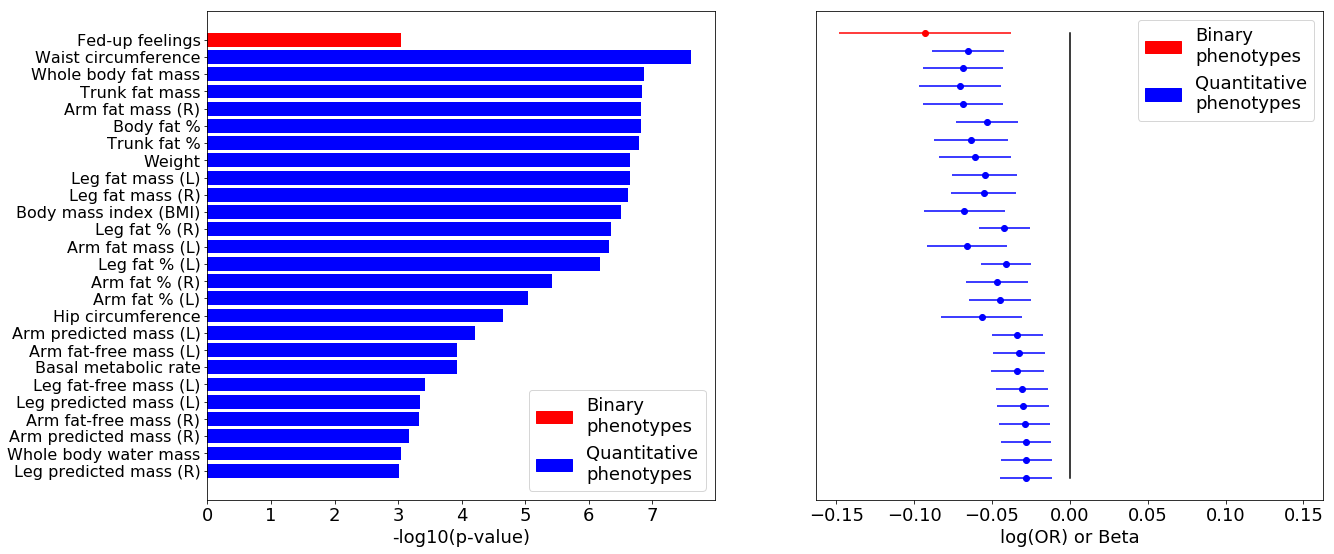

In [13]:
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
fig_axs = [fig.add_subplot(sp) for sp in gs]

vertical_pos = np.arange(len(df['l10pval']))
pheno_labels = df['Name'].map(
    lambda x: decomposition.label_txt_formatter(x, 23)
)

colors = ['red', 'blue']
color_legend_labels = ['Binary\nphenotypes', 'Quantitative\nphenotypes']

for color_index, is_bin in enumerate([True, False]):
    mask = df['is_binary'].map(lambda x: x is is_bin)
    fig_axs[0].barh(
        vertical_pos[mask], df['l10pval'][mask], 
        color=colors[color_index]
    )
    fig_axs[1].errorbar(
        df['LOR'][mask], vertical_pos[mask], 
        xerr=df['196SE'][mask], fmt='o', 
        color=colors[color_index]
    )

for ax in fig_axs:
    ax.invert_yaxis()
fig_axs[1].plot(np.zeros(len(vertical_pos)), vertical_pos, color='black')
fig_axs[0].set_yticklabels(pheno_labels, fontsize=16)
fig_axs[0].set_yticks(vertical_pos)
fig_axs[0].set_xlabel('-log10(p-value)')
fig_axs[1].set_xlabel('log(OR) or Beta')
fig_axs[1].get_yaxis().set_visible(False)

effect_size_plot_max = max(
    np.max((df['LOR'] + df['196SE']).map(lambda x: abs(x))), 
    np.max((df['LOR'] - df['196SE']).map(lambda x: abs(x)))
)
fig_axs[1].set_xlim((-effect_size_plot_max*1.1, effect_size_plot_max*1.1))


for ax in fig_axs:
    ax.legend(
        handles=[
            mpatches.Patch(color=colors[i], label=color_legend_labels[i]) 
            for i in range(len(color_legend_labels))
        ]
    )

        
for ext in ['pdf', 'png']:
    fig.savefig(
        os.path.join(out_dir, 'fig4_PheWAS_{}.{}'.format(PTV_name, ext)),
        bbox_inches="tight", pad_inches=0.0,
    )


In [14]:
'fig4_PheWAS_{}.{}'.format(PTV_name, ext)


'fig4_PheWAS_GPR151.png'

In [15]:
df['Name'].map(lambda x: decomposition.label_txt_formatter(x, 23))


0            Fed-up feelings
4        Waist circumference
7        Whole body fat mass
20            Trunk fat mass
8           Arm fat mass (R)
10                Body fat %
9                Trunk fat %
5                     Weight
14          Leg fat mass (L)
12          Leg fat mass (R)
6      Body mass index (BMI)
13             Leg fat % (R)
11          Arm fat mass (L)
15             Leg fat % (L)
16             Arm fat % (R)
19             Arm fat % (L)
2          Hip circumference
22    Arm predicted mass (L)
23     Arm fat-free mass (L)
28      Basal metabolic rate
27     Leg fat-free mass (L)
26    Leg predicted mass (L)
30     Arm fat-free mass (R)
25    Arm predicted mass (R)
29     Whole body water mass
24    Leg predicted mass (R)
Name: Name, dtype: object

In [16]:
df['Name']

0                Fed-up_feelings
4            Waist_circumference
7            Whole_body_fat_mass
20                Trunk_fat_mass
8           Arm_fat_mass_(right)
10           Body_fat_percentage
9           Trunk_fat_percentage
5                         Weight
14           Leg_fat_mass_(left)
12          Leg_fat_mass_(right)
6          Body_mass_index_(BMI)
13    Leg_fat_percentage_(right)
11           Arm_fat_mass_(left)
15     Leg_fat_percentage_(left)
16    Arm_fat_percentage_(right)
19     Arm_fat_percentage_(left)
2              Hip_circumference
22     Arm_predicted_mass_(left)
23      Arm_fat-free_mass_(left)
28          Basal_metabolic_rate
27      Leg_fat-free_mass_(left)
26     Leg_predicted_mass_(left)
30     Arm_fat-free_mass_(right)
25    Arm_predicted_mass_(right)
29         Whole_body_water_mass
24    Leg_predicted_mass_(right)
Name: Name, dtype: object

In [17]:
for x in df['Name']:
    print(x)
    

Fed-up_feelings
Waist_circumference
Whole_body_fat_mass
Trunk_fat_mass
Arm_fat_mass_(right)
Body_fat_percentage
Trunk_fat_percentage
Weight
Leg_fat_mass_(left)
Leg_fat_mass_(right)
Body_mass_index_(BMI)
Leg_fat_percentage_(right)
Arm_fat_mass_(left)
Leg_fat_percentage_(left)
Arm_fat_percentage_(right)
Arm_fat_percentage_(left)
Hip_circumference
Arm_predicted_mass_(left)
Arm_fat-free_mass_(left)
Basal_metabolic_rate
Leg_fat-free_mass_(left)
Leg_predicted_mass_(left)
Arm_fat-free_mass_(right)
Arm_predicted_mass_(right)
Whole_body_water_mass
Leg_predicted_mass_(right)


In [18]:
df[['icd', 'Name', 'Case', 'l10pval', 'LOR', '196SE']]


,icd,Name,Case,l10pval,LOR,196SE
0,BIN1960,Fed-up_feelings,136434,3.041,-0.09304,0.054978
4,INI48,Waist_circumference,336659,7.599,-0.06544,0.023010
7,INI23100,Whole_body_fat_mass,330970,6.870,-0.06872,0.025539
20,INI23128,Trunk_fat_mass,331295,6.835,-0.07053,0.026284
8,INI23120,Arm_fat_mass_(right),331422,6.816,-0.06863,0.025617
10,INI23099,Body_fat_percentage,331318,6.816,-0.05306,0.019816
9,INI23127,Trunk_fat_percentage,331314,6.790,-0.06356,0.023775
5,INI21002,Weight,336260,6.654,-0.06087,0.023030
14,INI23116,Leg_fat_mass_(left),331470,6.649,-0.05468,0.020698
12,INI23112,Leg_fat_mass_(right),331488,6.620,-0.05517,0.020933
